In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import wordcloud

import spacy
#spacy.cli.download("it_core_news_sm")
ITA_tokenizer = spacy.load("it_core_news_sm", disable=['parser', 'ner'])

num_topics = 3

it_stop_words = []#stopwords.words('italian')
custom_stop_words = ['me','xe', 'el', 'lettera', 'schmitz','ettore', 'signora', 'signore', 'scrivere', 'sapere','fare', 'cosa','essere']
it_stop_words.extend(custom_stop_words)
full_corpus = pd.read_csv('carteggio_svevo3.csv', sep=';')
ita_corpus = full_corpus[full_corpus['mainLanguage'] == 'ITA'].reset_index()
corpus_for_tfidf = full_corpus[full_corpus['mainLanguage'] == 'ITA'].reset_index()

Following the text of the project proposal the goal is to find:
- which are the main topics of discussion in the corpus, who are the people which each topic is more associated with, how does the interest on different topics evolve over the time

In [39]:
def tokenize_text(full_text):
    from nltk.tokenize import sent_tokenize, word_tokenize
    t_sent = sent_tokenize(full_text)
    t_words = []
    tk_sentence = []
    for sent in t1_sent:
        tk_sentence = ( word_tokenize(sent))
        for w in tk_sentence:
            t_words.append(w)

    return t_words

def adv_tokenizer(full_text):
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer('\w+')
    return tokenizer.tokenize(full_text)



def remove_stop_words(tokenized_text, stop_words):
    polished_text = [word for word in tokenized_text if not word in stop_words]
    return polished_text

def stemming(text):
    from nltk.stem import SnowballStemmer
    stemmer = SnowballStemmer('italian')
    return [stemmer.stem(word) for word in text]
 

def pre_proc(text, pos = ['PROPN', 'NOUN', 'VERB'], stop_words = it_stop_words ):
    #for the tokenization part we used a piece of software from spacy that performs 
    text = text.lower()
    doc = ITA_tokenizer(text)
    tokenized_text = []
    #tokenizing and lemmatizing on one shot
    for token in doc:
        if token.lemma_ not in stop_words and token.pos_ in pos and not token.is_stop and token.is_alpha:
            tokenized_text.append(token.lemma_)
            #print(token.pos_)
    return tokenized_text

def extract_topic_keywords(model, num_words, plot = True):
    #extracting for each topic the keywords and making some plots
    num_topics = len(model.print_topics())
    if plot:
        for t,w  in lda_model_tfidf.show_topics(formatted=False, num_topics=num_topics, num_words=num_words):
            
            print("Topic {} keywords:\n\n format['word','frequency']\n\n {}".format(t,w))

            w = dict(w)
            width = 800
            height = 600

            wcloud = wordcloud.WordCloud(width = width, height = height, background_color='White').generate_from_frequencies(w)
            plt.figure(dpi=150)
            plt.imshow(wcloud)
            plt.axis('off')
            plt.show()
    
    
    return [[tup2[0] for tup2 in tup[1]]for tup in model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words)]

def get_topic_scores(model, bow_corpus):
    #getting for each topic the score assigned for each topic
    corpus_scores = []
    for letter in bow_corpus:
        score = [0 for i in range(num_topics)]
        model_output =  model[letter]
        
        for out in model_output:
            i = out[0]
            score[i] = out[1]
        
        corpus_scores.append(score)
    return corpus_scores
            
    

In [3]:
sender = ita_corpus['sender']
recipient = ita_corpus['recipient']
important_people = ['Livia Veneziani','Eugenio Montale','Paul Henri Michel','Valerio Jahier','Marieanne Crémieux Comnène','James Joyce','Giuseppe Prezzolini','Ferdinando Pasini','Valéry Larbaud']
sr = []
for i in range(len(sender)):
    if sender[i] != 'Ettore Schmitz' and sender[i] in important_people:
        sr.append(sender[i])
    elif recipient[i] in important_people:
        sr.append(recipient[i])
    else:
        sr.append('OTHER')
ita_corpus['SR'] = sr  
ita_corpus['SR'].value_counts()

Livia Veneziani               608
OTHER                          63
Eugenio Montale                62
Paul Henri Michel              17
Valerio Jahier                 15
Marieanne Crémieux Comnène     14
James Joyce                    13
Giuseppe Prezzolini            12
Ferdinando Pasini              11
Valéry Larbaud                 11
Name: SR, dtype: int64

In [40]:
sender = corpus_for_tfidf['sender']
recipient = corpus_for_tfidf['recipient']
important_people = ['Livia Veneziani','Eugenio Montale','Paul Henri Michel','Valerio Jahier','Marieanne Crémieux Comnène','James Joyce','Giuseppe Prezzolini','Ferdinando Pasini','Valéry Larbaud']
sr = []
for i in range(len(sender)):
    if sender[i] != 'Ettore Schmitz' and sender[i] in important_people:
        sr.append(sender[i])
    elif recipient[i] in important_people:
        sr.append(recipient[i])
    else:
        sr.append('OTHER')
corpus_for_tfidf['SR'] = sr  
corpus_for_tfidf['SR'].value_counts()

Livia Veneziani               608
OTHER                          63
Eugenio Montale                62
Paul Henri Michel              17
Valerio Jahier                 15
Marieanne Crémieux Comnène     14
James Joyce                    13
Giuseppe Prezzolini            12
Ferdinando Pasini              11
Valéry Larbaud                 11
Name: SR, dtype: int64

In [4]:
processed_letters = []
for letter in ita_corpus['text']:
    

    tokenized_letter = pre_proc(letter,pos = ['PROPN', 'NOUN', 'VERB'])
    processed_letters.append(tokenized_letter)
  

In [5]:
import gensim
dictionary = gensim.corpora.Dictionary(processed_letters)
dictionary.filter_extremes(no_below=5, no_above=0.5)

dictionary_for_tfidf = gensim.corpora.Dictionary(processed_letters)

In [6]:
bow = [dictionary.doc2bow(doc) for doc in processed_letters]

bow_for_tfidf=[dictionary_for_tfidf.doc2bow(doc) for doc in processed_letters]

from gensim import corpora, models

tfidf = models.TfidfModel(bow_for_tfidf)
corpus_tfidf = tfidf[bow_for_tfidf]

In [7]:
lda_model = gensim.models.LdaMulticore(bow, num_topics=num_topics, id2word=dictionary, passes=10)

In [9]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary_for_tfidf, passes=10)


'for topic,words in lda_model_tfidf.show_topics(formatted=True, num_topics=num_topics, num_words=20):\n        print(str(topic)+ ": " + words + "\n\n\n")'

Topic 0 keywords:

 format['word','frequency']

 [('olga', 0.0019377084), ('marcare', 0.0015720042), ('sera', 0.0014971766), ('andare', 0.0014577808), ('venezia', 0.0014041795), ('titina', 0.0013711213), ('venire', 0.0013569721), ('letizia', 0.001347086), ('livia', 0.0013314995), ('baciare', 0.0013017925), ('trovare', 0.0012970119), ('notte', 0.0012883804), ('cuore', 0.0012673427), ('fabbricare', 0.0012665667), ('murare', 0.0012448101), ('sperare', 0.001242483), ('gilda', 0.0012376995), ('parere', 0.0012357541), ('sabato', 0.0012212587), ('arrivare', 0.001214603)]


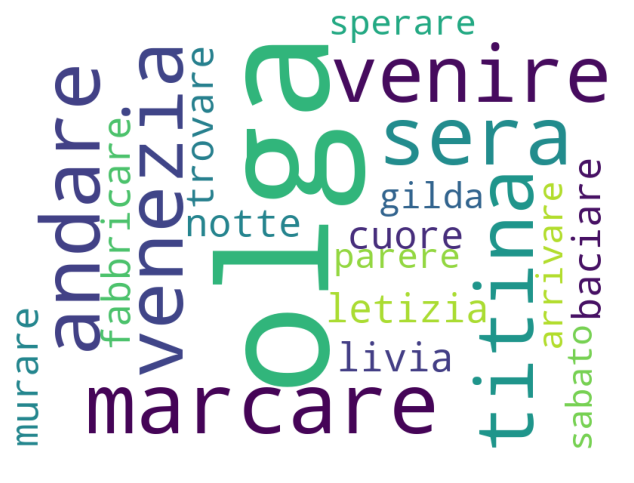

Topic 1 keywords:

 format['word','frequency']

 [('parigi', 0.0015004986), ('articolare', 0.0014771458), ('amicare', 0.001415251), ('senilità', 0.0013902587), ('trieste', 0.0012945482), ('librare', 0.0011654384), ('romanzare', 0.0011536342), ('mano', 0.0011434626), ('credere', 0.0011113498), ('veneziano', 0.0011015029), ('crémieux', 0.0010811259), ('villa', 0.0010517597), ('editore', 0.0009832775), ('arrivare', 0.0009622791), ('larbaud', 0.0009503817), ('joyce', 0.000889926), ('sperare', 0.0008799663), ('zeno', 0.0008543359), ('vedere', 0.0008389974), ('traduzione', 0.00083625736)]


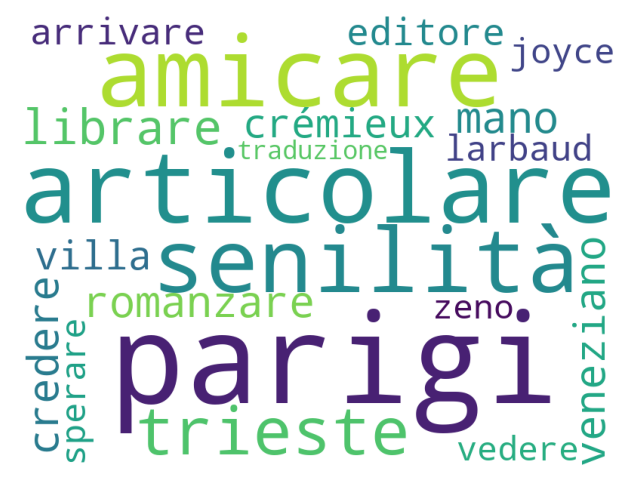

Topic 2 keywords:

 format['word','frequency']

 [('fumare', 0.0004061229), ('vecio', 0.00033825563), ('bellagio', 0.00030560236), ('brescia', 0.0003007624), ('zanutto', 0.00028431465), ('mackay', 0.0002804431), ('vizii', 0.00027935038), ('poetare', 0.00026780632), ('coda', 0.00026430335), ('testare', 0.0002630999), ('grasso', 0.0002604633), ('fumo', 0.0002589348), ('pitturazioni', 0.00025772804), ('mandel', 0.00025507502), ('promettere', 0.00025313575), ('armadii', 0.0002501723), ('darwin', 0.00024768684), ('fastidii', 0.00024106806), ('riconquistare', 0.00023786086), ('opus', 0.00023785808)]


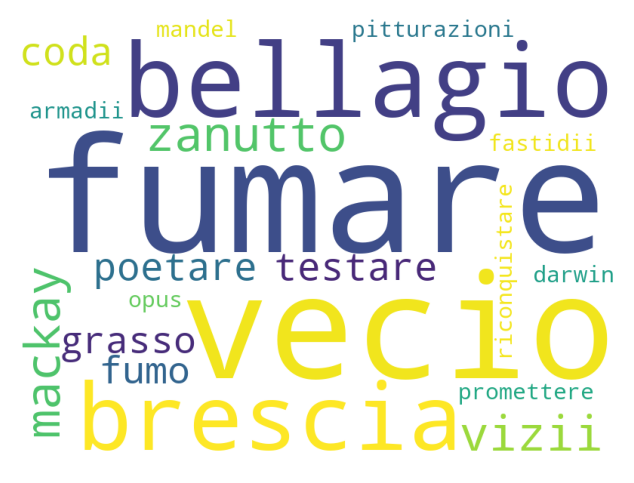

Topic 0:

['cuore', 'olga', 'ricevere', 'parere', 'andare', 'sera', 'arrivare', 'sperare', 'vedere', 'notte', 'titina', 'venire', 'trovare', 'venezia', 'marcare', 'mattina', 'letizia', 'trieste', 'restare', 'fabbricare']

Topic 1:

['trovare', 'baciare', 'parere', 'cuore', 'trieste', 'ricevere', 'credere', 'restare', 'parlare', 'olga', 'marcare', 'parola', 'vedere', 'andare', 'bisognare', 'pensare', 'venire', 'londra', 'titina', 'sentire']

Topic 2:

['trieste', 'credere', 'amicare', 'senilità', 'articolare', 'parigi', 'parere', 'librare', 'mano', 'sperare', 'veneziano', 'vedere', 'romanzare', 'parlare', 'pensare', 'parola', 'villa', 'ricevere', 'piacere', 'bisognare']



In [24]:
key_words = extract_topic_keywords(lda_model, 20)

for i in range(len(key_words)):
    print("Topic {}:\n\n{}\n".format(i,key_words[i]))

In [28]:
scores = get_topic_scores(lda_model, bow)
letter_topics = list(map(np.argmax, scores))
ita_corpus['topic_scores'] = scores
ita_corpus['topic'] = letter_topics

In [29]:
people = []
important_people = ['Livia Veneziani','Eugenio Montale','Paul Henri Michel','Valerio Jahier','Marieanne Crémieux Comnène','James Joyce','Giuseppe Prezzolini','Ferdinando Pasini','Valéry Larbaud']

people = important_people
people.append('OTHER')

for person in people:
    sub_data_index = ita_corpus['SR'] == person
    sub_data = ita_corpus[sub_data_index]
    val_count = sub_data['topic'].value_counts()
    print("Person: {}".format(person))
    print("Topics")
    print(val_count)
    print("--- --- --- --- \n")

Person: Livia Veneziani
Topics
0    436
1    149
2     23
Name: topic, dtype: int64
--- --- --- --- 

Person: Eugenio Montale
Topics
2    62
Name: topic, dtype: int64
--- --- --- --- 

Person: Paul Henri Michel
Topics
2    17
Name: topic, dtype: int64
--- --- --- --- 

Person: Valerio Jahier
Topics
2    15
Name: topic, dtype: int64
--- --- --- --- 

Person: Marieanne Crémieux Comnène
Topics
2    14
Name: topic, dtype: int64
--- --- --- --- 

Person: James Joyce
Topics
2    13
Name: topic, dtype: int64
--- --- --- --- 

Person: Giuseppe Prezzolini
Topics
2    12
Name: topic, dtype: int64
--- --- --- --- 

Person: Ferdinando Pasini
Topics
2    8
1    3
Name: topic, dtype: int64
--- --- --- --- 

Person: Valéry Larbaud
Topics
2    11
Name: topic, dtype: int64
--- --- --- --- 

Person: OTHER
Topics
2    43
1    11
0     9
Name: topic, dtype: int64
--- --- --- --- 



In [30]:
year = ita_corpus['year']
min_y = min(year)
max_y = max(year)

In [31]:
topic_per_year = []
for y in range(min_y,max_y+1):
    counts = [0 for i in range(num_topics)]
    tpy = ita_corpus[ita_corpus['year'] == y]['topic']
    for topic in tpy:
        counts[topic] += 1 
    topic_per_year.append(counts)
    
        
    

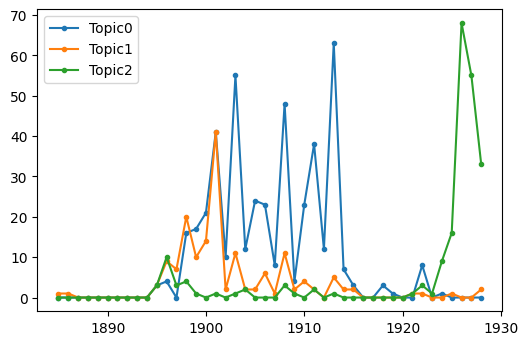

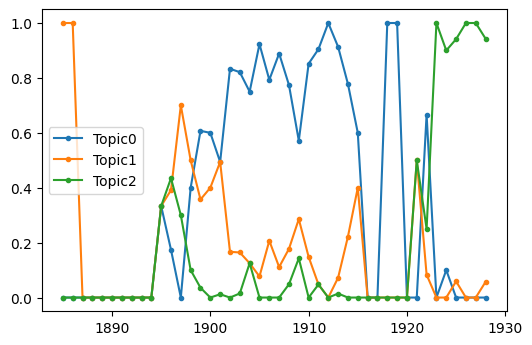

In [32]:
yy = [y for y in range(min_y,max_y+1)]
topic_per_year = np.array(topic_per_year, dtype = float)
plt.figure(dpi = 100)
for topic in range(num_topics):
    plt.plot(yy, topic_per_year[:,topic], '.-', label = "Topic" + str(topic))
plt.legend()
plt.figure(dpi = 100)

topic_per_year_norm = np.zeros_like(topic_per_year)

for i in range(len(topic_per_year)):
    if np.sum(topic_per_year[i,:]) != 0:
       
        topic_per_year_norm[i,:] = topic_per_year[i,:]/np.sum(topic_per_year[i,:])
        #print(np.sum(topic_per_year[i,:]), topic_per_year_norm[i,:])



for topic in range(num_topics):
    plt.plot(yy, topic_per_year_norm[:,topic], '.-', label = "Topic" + str(topic))
_ = plt.legend()

Are the identified topics understandable?

Are the topics coherent?

Does the topic model serve the purpose it is being used for?


Topic 0 keywords:

 format['word','frequency']

 [('olga', 0.0019377084), ('marcare', 0.0015720042), ('sera', 0.0014971766), ('andare', 0.0014577808), ('venezia', 0.0014041795), ('titina', 0.0013711213), ('venire', 0.0013569721), ('letizia', 0.001347086), ('livia', 0.0013314995), ('baciare', 0.0013017925), ('trovare', 0.0012970119), ('notte', 0.0012883804), ('cuore', 0.0012673427), ('fabbricare', 0.0012665667), ('murare', 0.0012448101), ('sperare', 0.001242483), ('gilda', 0.0012376995), ('parere', 0.0012357541), ('sabato', 0.0012212587), ('arrivare', 0.001214603)]


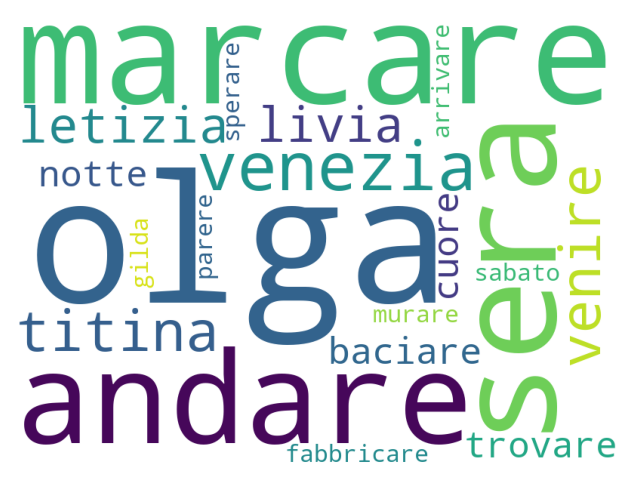

Topic 1 keywords:

 format['word','frequency']

 [('parigi', 0.0015004986), ('articolare', 0.0014771458), ('amicare', 0.001415251), ('senilità', 0.0013902587), ('trieste', 0.0012945482), ('librare', 0.0011654384), ('romanzare', 0.0011536342), ('mano', 0.0011434626), ('credere', 0.0011113498), ('veneziano', 0.0011015029), ('crémieux', 0.0010811259), ('villa', 0.0010517597), ('editore', 0.0009832775), ('arrivare', 0.0009622791), ('larbaud', 0.0009503817), ('joyce', 0.000889926), ('sperare', 0.0008799663), ('zeno', 0.0008543359), ('vedere', 0.0008389974), ('traduzione', 0.00083625736)]


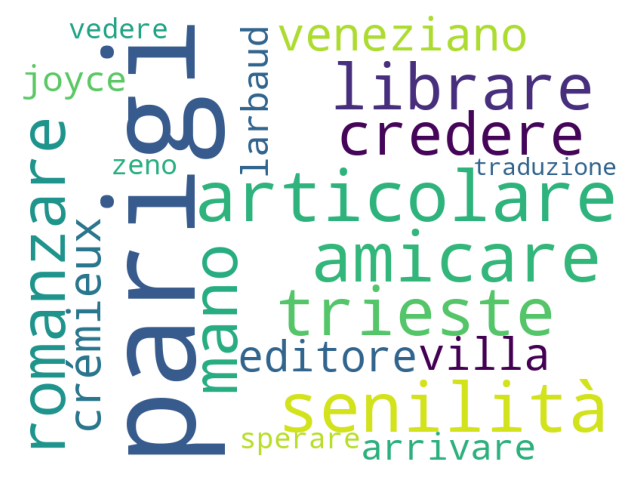

Topic 2 keywords:

 format['word','frequency']

 [('fumare', 0.0004061229), ('vecio', 0.00033825563), ('bellagio', 0.00030560236), ('brescia', 0.0003007624), ('zanutto', 0.00028431465), ('mackay', 0.0002804431), ('vizii', 0.00027935038), ('poetare', 0.00026780632), ('coda', 0.00026430335), ('testare', 0.0002630999), ('grasso', 0.0002604633), ('fumo', 0.0002589348), ('pitturazioni', 0.00025772804), ('mandel', 0.00025507502), ('promettere', 0.00025313575), ('armadii', 0.0002501723), ('darwin', 0.00024768684), ('fastidii', 0.00024106806), ('riconquistare', 0.00023786086), ('opus', 0.00023785808)]


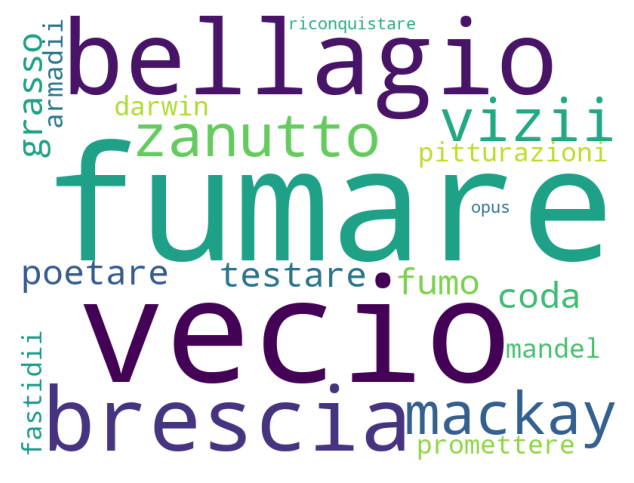

Topic 0:

['olga', 'marcare', 'sera', 'andare', 'venezia', 'titina', 'venire', 'letizia', 'livia', 'baciare', 'trovare', 'notte', 'cuore', 'fabbricare', 'murare', 'sperare', 'gilda', 'parere', 'sabato', 'arrivare']

Topic 1:

['parigi', 'articolare', 'amicare', 'senilità', 'trieste', 'librare', 'romanzare', 'mano', 'credere', 'veneziano', 'crémieux', 'villa', 'editore', 'arrivare', 'larbaud', 'joyce', 'sperare', 'zeno', 'vedere', 'traduzione']

Topic 2:

['fumare', 'vecio', 'bellagio', 'brescia', 'zanutto', 'mackay', 'vizii', 'poetare', 'coda', 'testare', 'grasso', 'fumo', 'pitturazioni', 'mandel', 'promettere', 'armadii', 'darwin', 'fastidii', 'riconquistare', 'opus']



In [33]:
key_words = extract_topic_keywords(lda_model_tfidf, 20)

for i in range(len(key_words)):
    print("Topic {}:\n\n{}\n".format(i,key_words[i]))

In [45]:
scores = get_topic_scores(lda_model_tfidf, bow_for_tfidf)
letter_topics = list(map(np.argmax, scores))
corpus_for_tfidf['topic_scores'] = scores
corpus_for_tfidf['topic'] = letter_topics

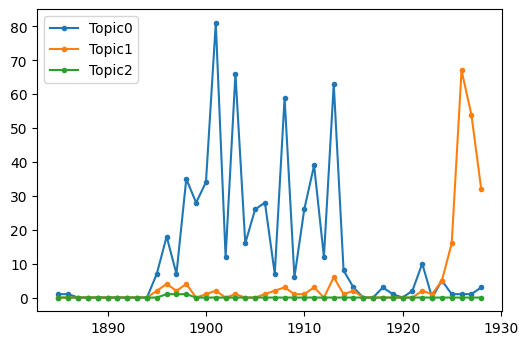

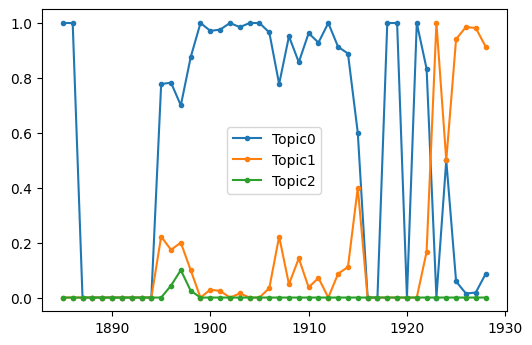

In [46]:
topic_per_year = []
for y in range(min_y,max_y+1):
    counts = [0 for i in range(num_topics)]
    tpy = corpus_for_tfidf[corpus_for_tfidf['year'] == y]['topic']
    for topic in tpy:
        counts[topic] += 1 
    topic_per_year.append(counts)


yy = [y for y in range(min_y,max_y+1)]
topic_per_year = np.array(topic_per_year, dtype = float)
plt.figure(dpi = 100)
for topic in range(num_topics):
    plt.plot(yy, topic_per_year[:,topic], '.-', label = "Topic" + str(topic))
plt.legend()
plt.figure(dpi = 100)

topic_per_year_norm = np.zeros_like(topic_per_year)

for i in range(len(topic_per_year)):
    if np.sum(topic_per_year[i,:]) != 0:
       
        topic_per_year_norm[i,:] = topic_per_year[i,:]/np.sum(topic_per_year[i,:])
        #print(np.sum(topic_per_year[i,:]), topic_per_year_norm[i,:])



for topic in range(num_topics):
    plt.plot(yy, topic_per_year_norm[:,topic], '.-', label = "Topic" + str(topic))
_ = plt.legend()

In [48]:
people = []
important_people = ['Livia Veneziani','Eugenio Montale','Paul Henri Michel','Valerio Jahier','Marieanne Crémieux Comnène','James Joyce','Giuseppe Prezzolini','Ferdinando Pasini','Valéry Larbaud']

people = important_people
people.append('OTHER')

for person in people:
    sub_data_index = corpus_for_tfidf['SR'] == person
    sub_data = corpus_for_tfidf[sub_data_index]
    val_count = sub_data['topic'].value_counts()
    print("Person: {}".format(person))
    print("Topics")
    print(val_count)
    print("--- --- --- --- \n")

Person: Livia Veneziani
Topics
0    575
1     30
2      3
Name: topic, dtype: int64
--- --- --- --- 

Person: Eugenio Montale
Topics
1    61
0     1
Name: topic, dtype: int64
--- --- --- --- 

Person: Paul Henri Michel
Topics
1    17
Name: topic, dtype: int64
--- --- --- --- 

Person: Valerio Jahier
Topics
1    15
Name: topic, dtype: int64
--- --- --- --- 

Person: Marieanne Crémieux Comnène
Topics
1    13
0     1
Name: topic, dtype: int64
--- --- --- --- 

Person: James Joyce
Topics
1    10
0     3
Name: topic, dtype: int64
--- --- --- --- 

Person: Giuseppe Prezzolini
Topics
1    12
Name: topic, dtype: int64
--- --- --- --- 

Person: Ferdinando Pasini
Topics
1    6
0    5
Name: topic, dtype: int64
--- --- --- --- 

Person: Valéry Larbaud
Topics
1    11
Name: topic, dtype: int64
--- --- --- --- 

Person: OTHER
Topics
1    38
0    25
Name: topic, dtype: int64
--- --- --- --- 

